##Pediction New Death Cases Global Covid-19 Cases

####Load Data and Import Libraries

In [1]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
%tensorflow_version 2.x # make sure that collab use tensorflow 2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # make sure that collab use tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !rm '/root/.keras/datasets/global_total.csv'

####Load Data


In [0]:
df_new_cases = pd.read_csv("https://raw.githubusercontent.com/virgiawan/covid-19-prediction/linear-regression/dataset/corona-virus/new_cases.csv")

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [0]:
step = 0;
times = []
series = []

for case in df_new_cases['World']:
  times.append(step)
  series.append(case)
  step += 1

Total data 151 series


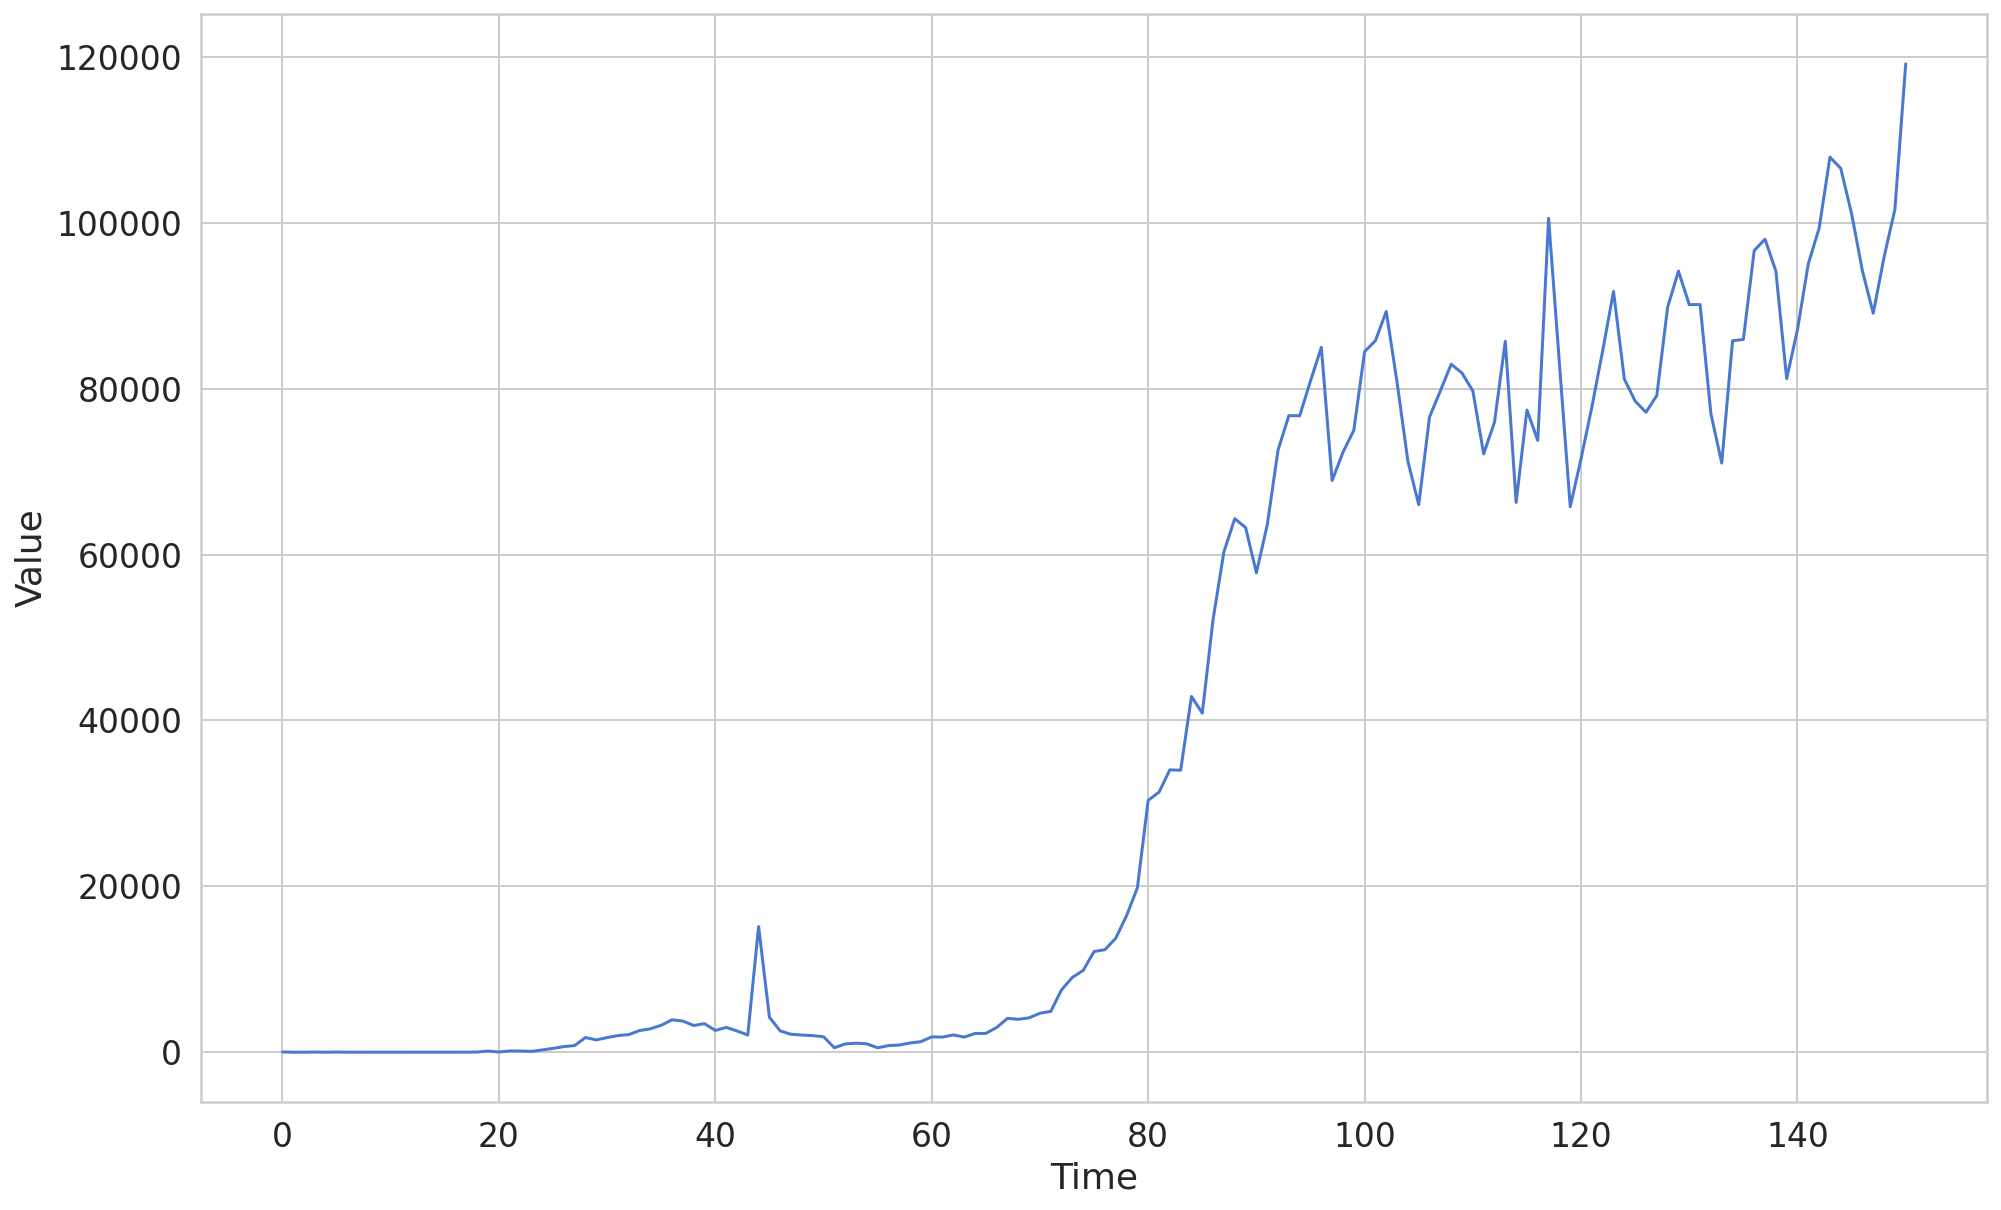

In [6]:
plot_series(times, series)
print('Total data {} series'.format(len(series)))

Total data 88 series


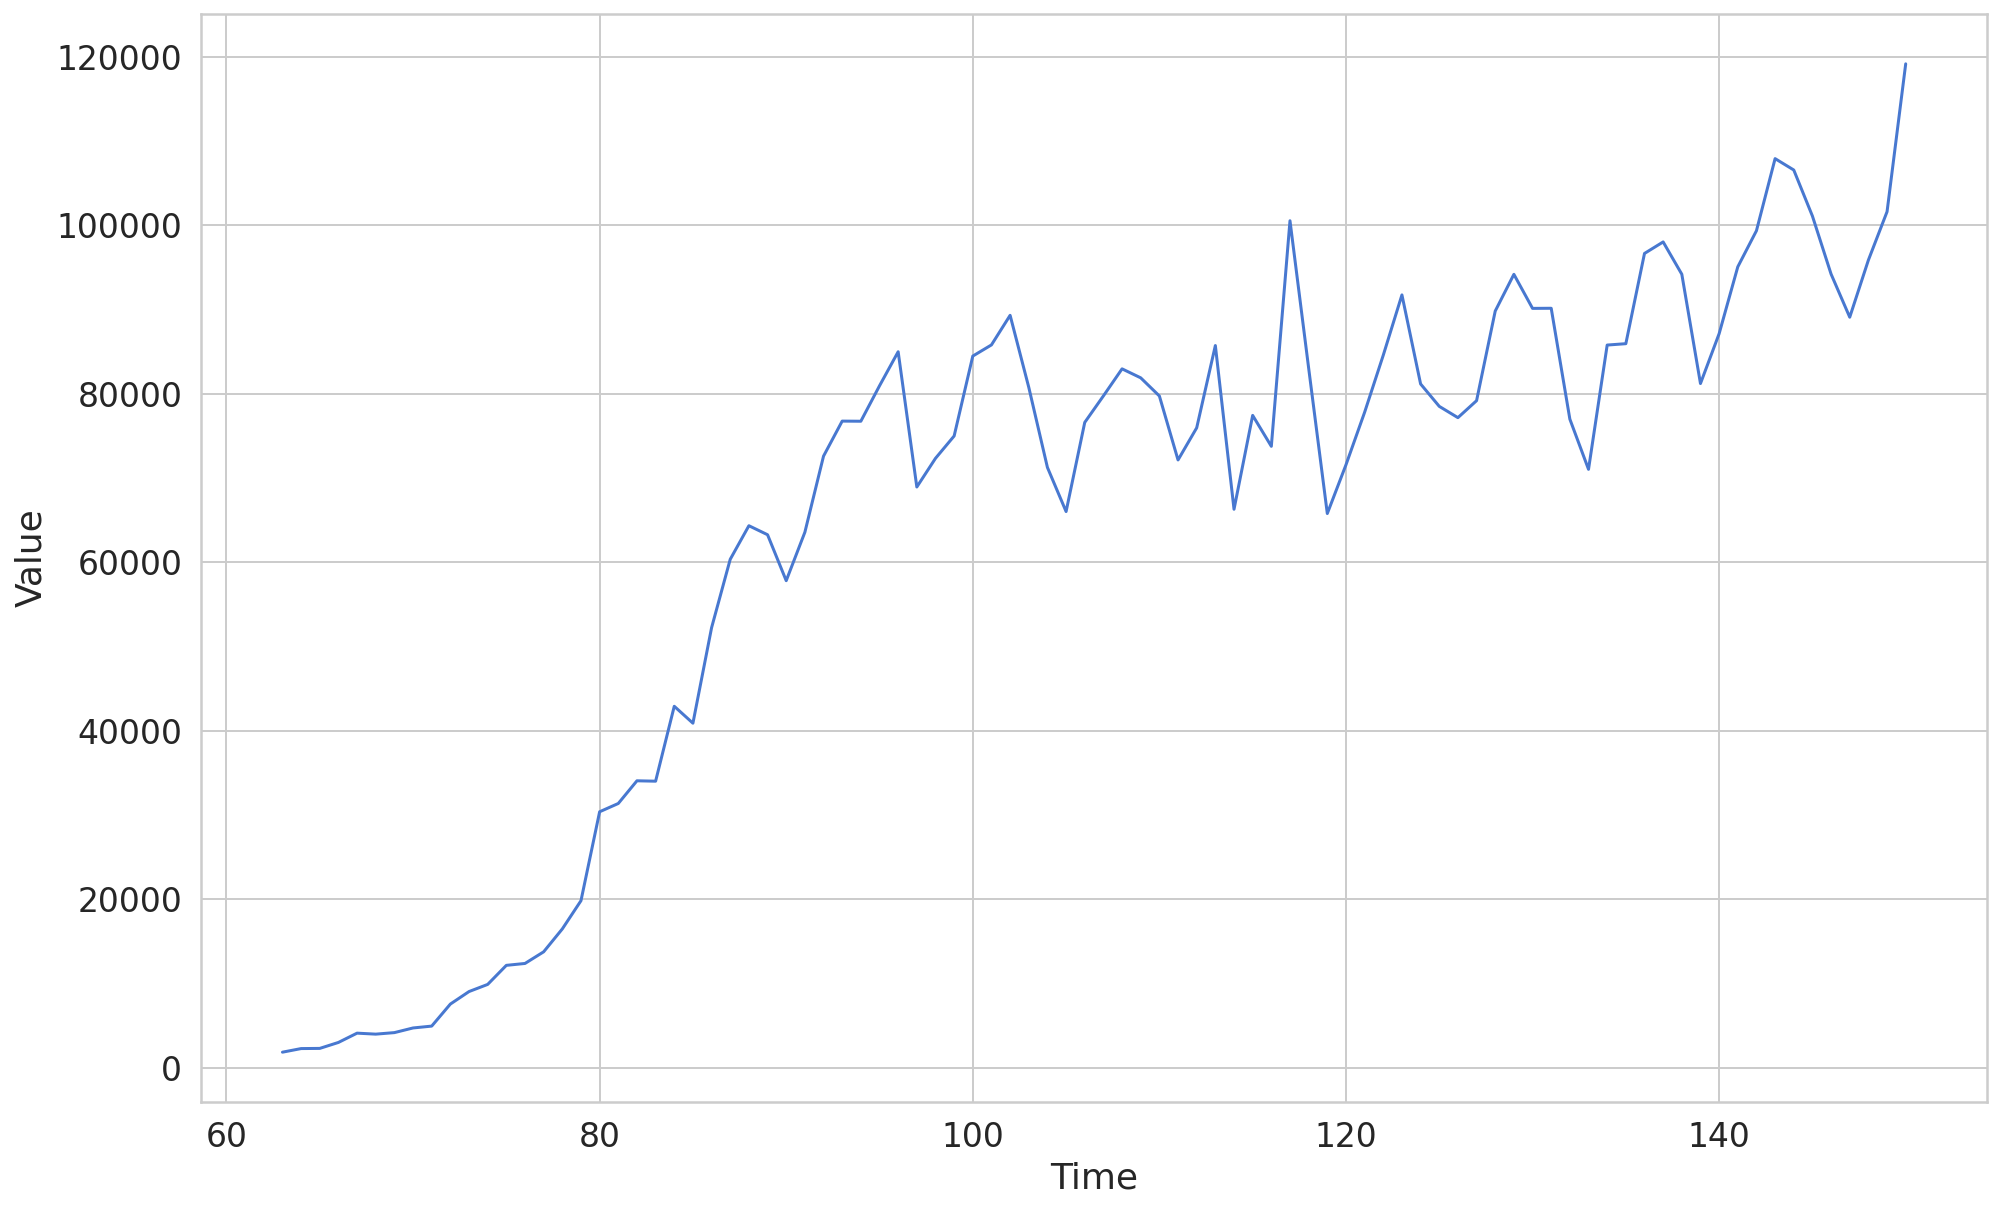

In [8]:
# Series 0 - 63 indicate flat data. Data not increased significantly. 
# Try to ignore it first
skip = 63
used_series = series[skip:]
used_times = times[skip:]

plot_series(used_times, used_series)
print('Total data {} series'.format(len(used_series)))

In [0]:
split_percentage = 0.70
split_time = (int) (len(used_times) * split_percentage)

time_train = used_times[:split_time]
x_train = used_series[:split_time]
time_valid = used_times[split_time:]
x_valid = used_series[split_time:]

In [0]:
# create DNN window
def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [0]:
# dataset = tf.data.Dataset.from_tensor_slices(x_train)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)

# for window_dataset in dataset:
#   for val in window_dataset:
#     print(val.numpy(), end=" ")
#   print()

In [0]:
# define hyper parameter
window_size = 7
batch_size = 2
shuffle_buffer_size = 10
epochs = 100

(1e-10, 10.0, 0.0, 100000.0)

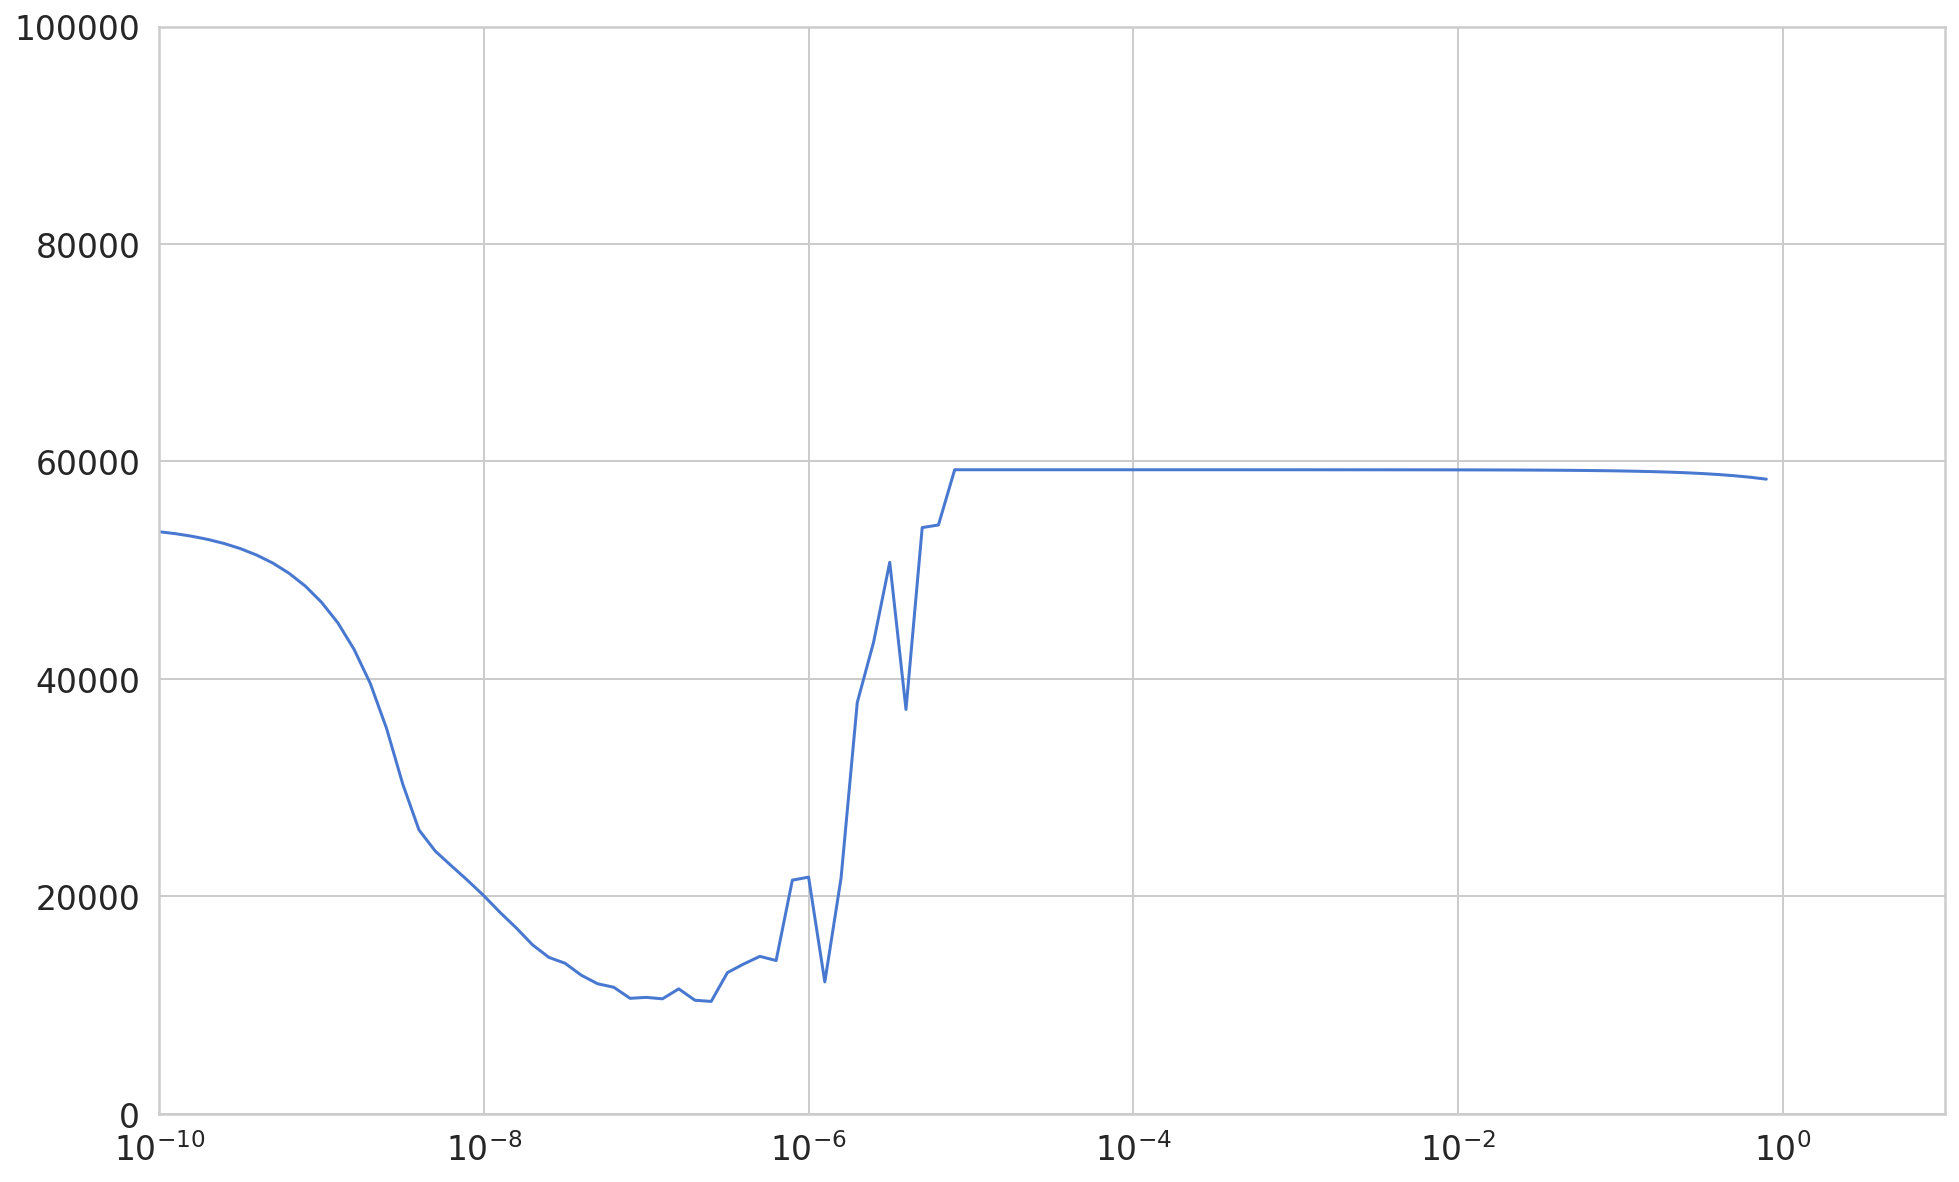

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1])
l1 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0,  l1])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=epochs, callbacks=[lr_schedule], verbose=0)

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-10, 10, 0, 100000])

Loss [11750.53125]


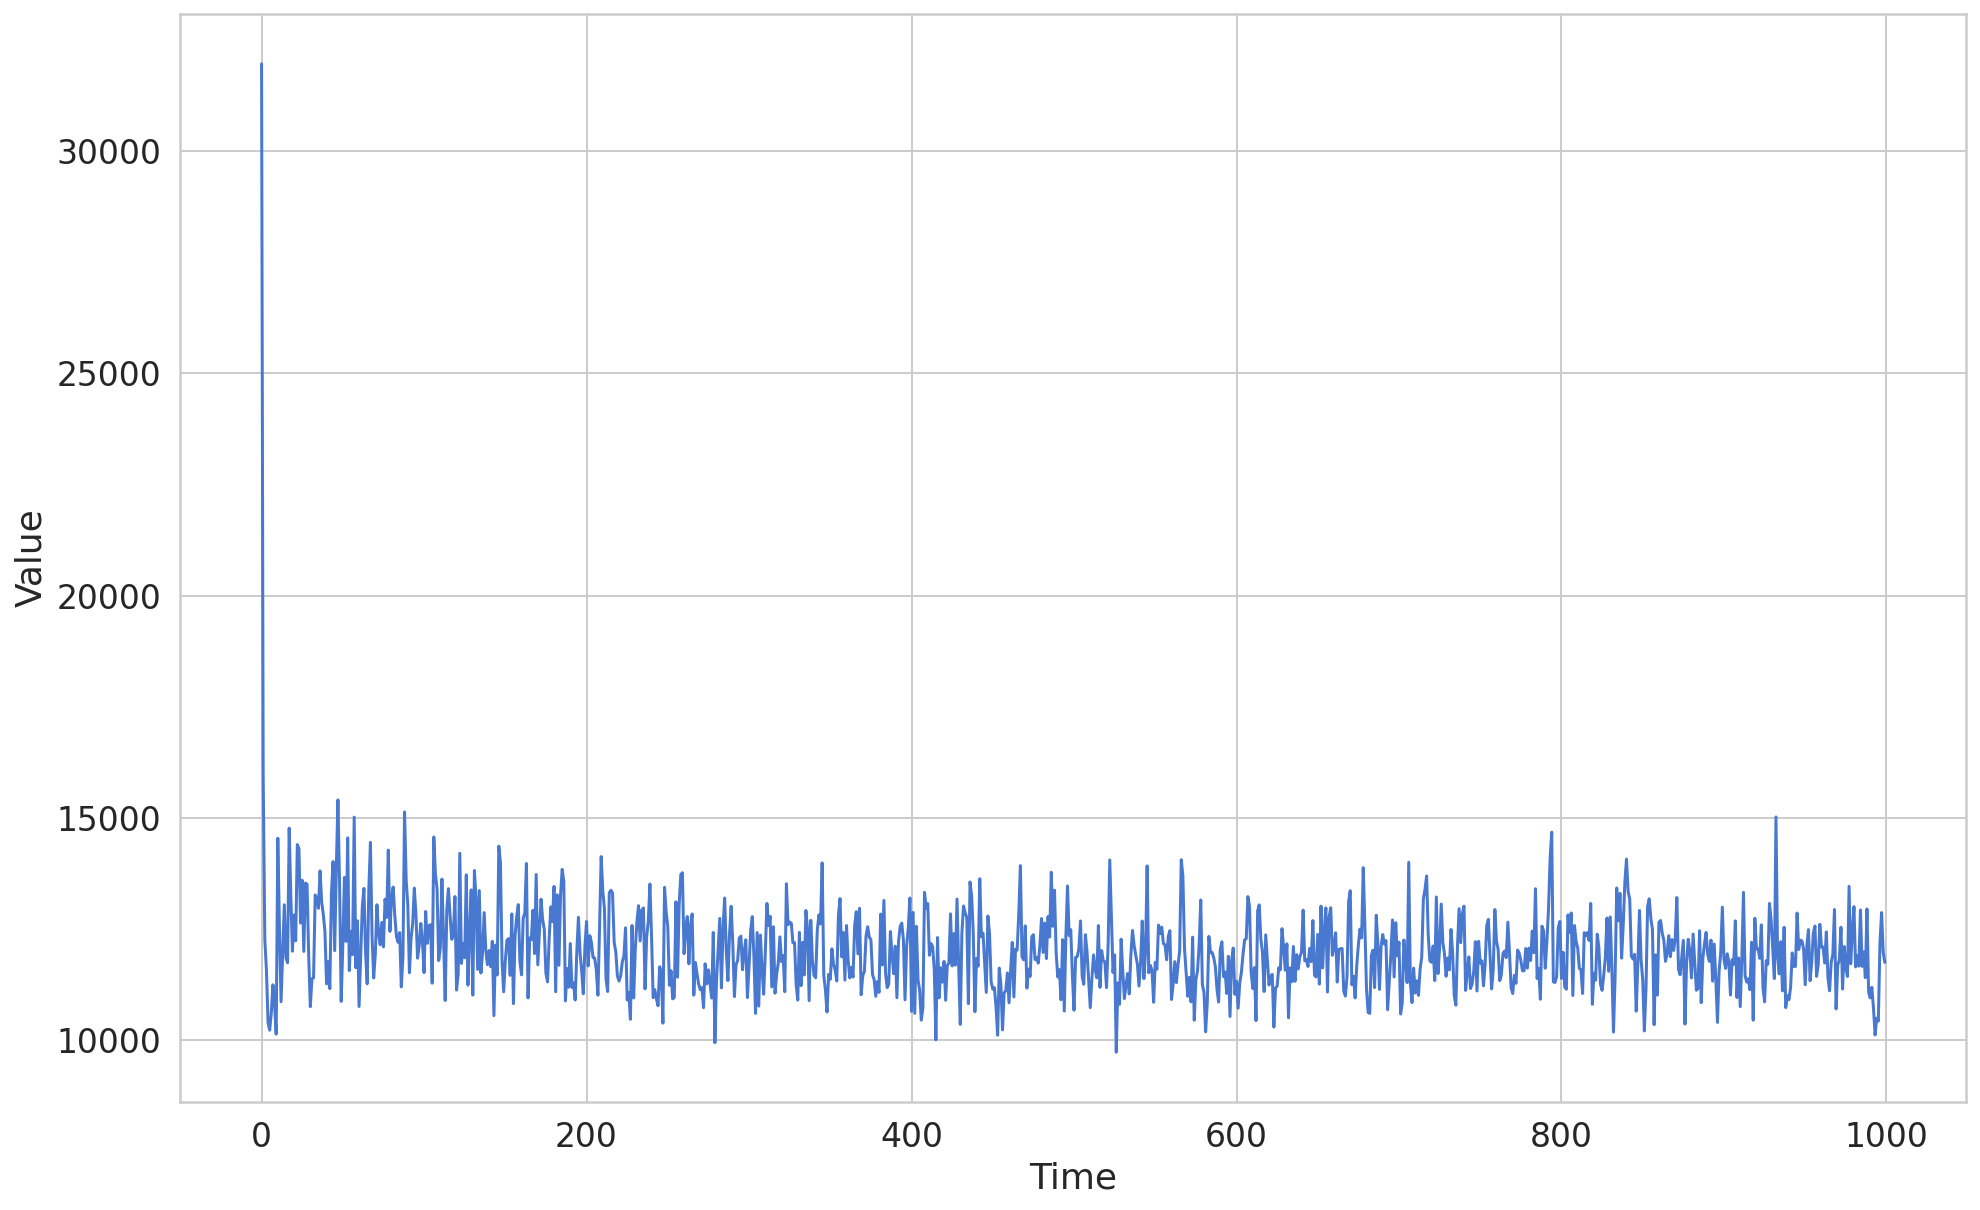

In [33]:
# define hyper parameter
window_size = 7
batch_size = 2
shuffle_buffer_size = 10
epochs = 1000

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1])
l1 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0, l1])

model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
history = model.fit(dataset,epochs=epochs, verbose=0)
loss = history.history['loss']

print("Loss {}".format(loss[-1:]))
plot_series(range(0, epochs), loss)
# print("Layer weights {}".format(l0.get_weights()))

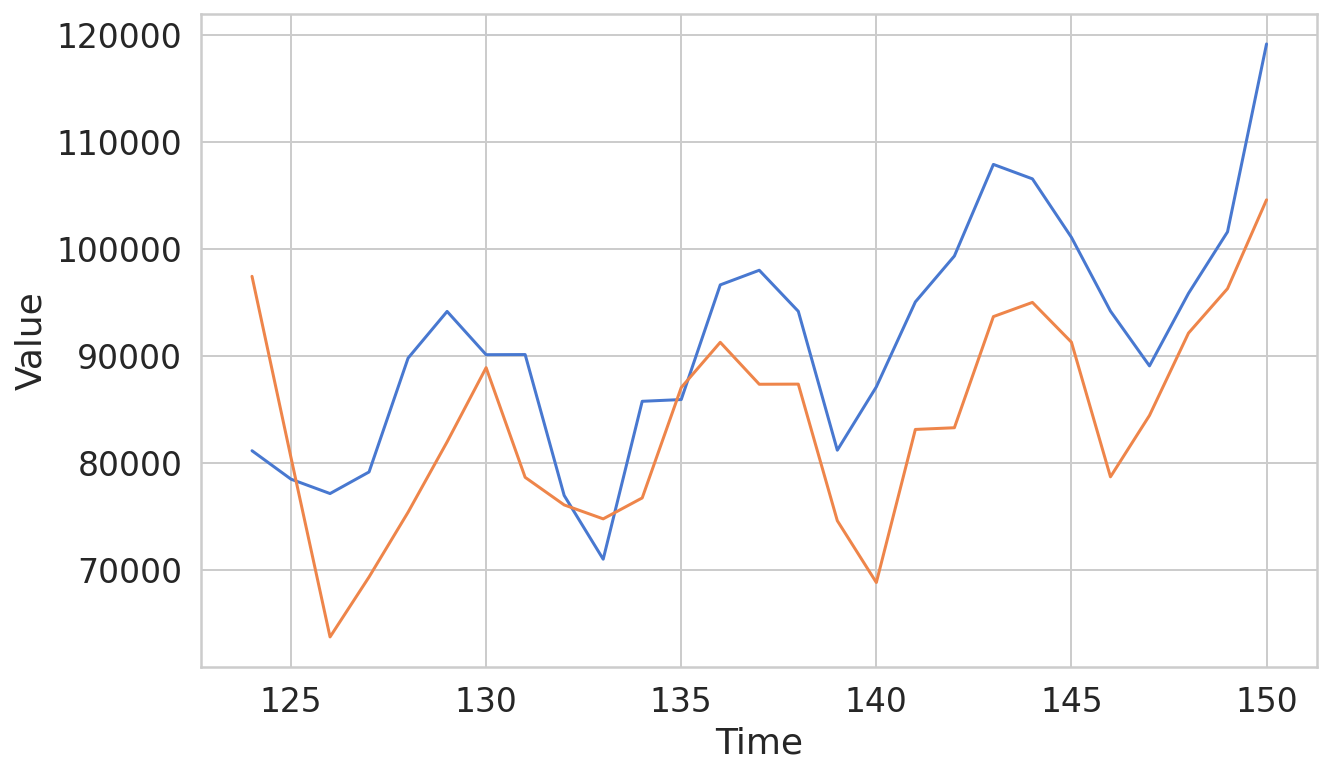

In [35]:
forecast = []
np_used_series = np.array(used_series)
np_used_series = tf.expand_dims(np_used_series, axis=-1)

for time in range(len(np_used_series) - window_size):
  forecast.append(model.predict(np_used_series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

array([ 9900.082, 12330.902, 27618.096, 22012.322, 16287.887, 11515.72 ,
        8762.37 , 13519.824, 15656.91 , 16862.322, 15051.064,  9249.189,
        8591.169,  9164.471,  9161.204, 17021.184, 22530.93 , 10955.183,
       10879.108,  8680.206,  8913.683,  8591.563, 13487.08 , 10325.566,
        8623.121,  9372.724, 14701.32 ], dtype=float32)